# Homework 07

## Group 10

## Data set

This week we are going to build an autoencoder. In fact we are building two autoencoders. First a simple convolutional one and then a variational autoencoder. The dataset we are going to use is the fashion mnist dataset which we can conveniently import from keras. So let's get started, import it and take a look at what we are dealing with this week.

But what exactly are autoencoders? When we look at all kinds of data we see that we could represent this data in a much simpler way and in a much lower dimensional space than the actual data. These representations are called embeddings. Autoencoders are often used to compress the data.

In our case, the autoencoder takes the input images, runs it through the first part neural network (called encoder) in order to compress the data into a smaller representation (embedding). The second part of the network (called the decoder) takes this embedding as input and tries to reconstruct the initial input images.

**input image** $\longrightarrow$ endoder $\longrightarrow$ **embedding** $\longrightarrow$ decoder $\longrightarrow$ **deconstructed image**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Now that our data is loaded, take a look at the formatting and general structure.

In [3]:
train_images[0].shape

(28, 28)

In [4]:
print(f"Train image shape: {train_images.shape} \nTest image shape: {test_images.shape}")

Train image shape: (60000, 28, 28) 
Test image shape: (10000, 28, 28)


So there are 60000 training images with a size of 28x28 pixels, as well as 10000 test images with the same dimension. Let's plot some examples. Since the labels are only numbers again, we are going to apply the same technique as in the last couple of weeks by using a helper function to match the number to the corresponding word label.

Also notice that our images are only grayscale this week and not RGB colored as the CIFAR10 dataset. So we have to pass a colormap (cmap) to matplotlib otherwise it will use its default color scheme for the images.

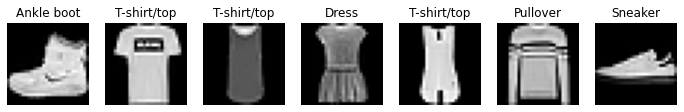

In [5]:
def word_labels(label):
    """Little helper function to map a label to the corresponding word"""
    label_words = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    return label_words[int(label)]

fig, ax = plt.subplots(1, 7, figsize=(12,6))

for i in range(len(ax)):

    ax[i].imshow(train_images[i], cmap="gray")
    ax[i].set_title(word_labels(train_labels[i]))
    ax[i].axis("off")


# Input Pipeline

This week's input pipeline is a little shorter than the last ones. Since our autoencoders learn unsupervised, we will disregard the labels and only process the images.

The rest is pretty much what you would expect. First normalizing the images and casting them into tensorflow floats, reshaping the input to match our convolutional layers. Then shuffling, batching and prefetching our datasets for training and testing.

In [6]:
# Input Pipeline

# Hyperparameters
batch_size = 64
prefetch_size = tf.data.experimental.AUTOTUNE

# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_data= tf.data.Dataset.from_tensor_slices(train_images)

#we normalize our data and center the pixel values around zero
train_data = train_data.map(lambda img : (tf.cast(img/255, tf.float32)))
train_data = train_data.map(lambda img : tf.reshape(img, (28,28,1)))
train_data = train_data.shuffle(buffer_size=128)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(prefetch_size)

# repeat for the test dataset
test_data = tf.data.Dataset.from_tensor_slices(test_images)
test_data = test_data.map(lambda img : (tf.cast(img/255, tf.float32)))
test_data = test_data.map(lambda img : tf.reshape(img, (28,28,1)))
test_data = test_data.shuffle(buffer_size=128)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(prefetch_size)

# Model

## Convolutional Autoencoder

The first model we are going to build is a Convolutional Autoencoder. To simplify the code we are subclassing our `Encoder` and `Decoder` and bring them together later in the `ConvolutionalAutoencoder` class. The general setup is pretty straightforward if you have seen our other homework. We define a list of layers in the `__init__()` method and then loop over that list during the `call()`. This keeps our `call` method nice and small and allows quick changes of our layout simply by adding or removing layers in the `__init__()` method.

For the `Encoder` we start with two Convolutional layers, which will reduce our 28x28 input images to 7x7. This input then gets flattened and put through a Dense layer with relu as activation function.

In our `Decoder` we reverse the steps of our `Encoder` to reconstruct the image. First we feed our embedding through a 28x28=784 Dense layer with sigmoid activation. Afterwards we reshape our data back into 28x28 pixels with grayscale values. Now comes the convolutional upsampling. `Conv2DTranspose` layers will "invert" the effect of the convolutional layers, as shown in this week's lecture. The last layer is a convolutional layer with 1 filter and 28 by 28 kernel size, to bring the final reconstruction together, activated by a sigmoid function.

The `Convolutional Autoencoder` class instantiates our `Encoder` and `Decoder`, feeds the embeddings into our decoder and finally returns the encoded image.

In [7]:
# Convolutional Autoencoder
from tensorflow.keras import layers


class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.layer_list = [
            layers.Conv2D(16,kernel_size = 3,strides=2),
            layers.Conv2D(8,kernel_size = 3,strides=2),
            layers.Flatten(),
            layers.Dense(latent_dim, activation="relu")
        ]
    
    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x
        

class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer_list = [
            layers.Dense(784, activation="sigmoid"),
            layers.Reshape((28, 28, 1)),
            layers.Conv2DTranspose(1, 14),
            layers.Conv2DTranspose(1, 15),
            layers.Conv2D(1, 28, activation='sigmoid')
        ]

    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x


class ConvolutionalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder()

    def call(self, x, training=False):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
conv_model = ConvolutionalAutoencoder(64)
conv_model.build(input_shape=(64,28,28,1))
conv_model.summary()

Model: "convolutional_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  19816     
_________________________________________________________________
decoder (Decoder)            multiple                  52168     
Total params: 71,984
Trainable params: 71,984
Non-trainable params: 0
_________________________________________________________________


## Variational Autoencoder

Now we will take a closer look at variational autoencoders. Variational autoencoders are, in contrast to convolutional autoencoders, generative models. In other words, it is not only possible to reconstruct images the network has seen before but it can generate new images based on some random vectors. 

What is important to note here is that the network learns a probability distribution over the embedding, more specifically, a Gaussian distribution. We map the input onto a distribution. The **encoder**, therefore, does not only output one vector but two vectors. One for the mean ($\mu$) and one for the standard deviation ($\sigma$) (`encode`method). This means, even if the input is the same the encoding will vary each time - it is probabilistic. 

The **decoder** works like a usual decoder. But this way the decoder learns that points in the latent space that are close to each other refer to the same class. The decoder learns to decode encodings that vary a little (because during the training it faces slightly different versions of the encoding as described above) (`decode`method). 

To make this a little bit more intuitive and closer to the dataset: for example boots and sandals would be close to each other in the latent space because they refer to the same class. Else we would not get meaningful representations of new samples. 

But there is something that we need to take care of. After the encoder we have a sampling operation. So after the bottleneck there is a node that takes a sample of a distribution and feeds this through the decoder. But this causes problems with our usual backpropagation since we cannot push gradients through a sampling operation. Therefore, we need the so-called **reparameterization trick**. If you look at the latent vector that you are sampling you can look at this vector as the sum of a fixed mean and a sigma (both are parameters that are learned) multiplied with an epsilon ($\mu$ + $\sigma$ * $\epsilon$). The $\epsilon$ is always a standard Gaussian ($\mu$ = 0 and $\sigma$ = 1). So we sample from the $\epsilon$ multiply it with the standard deviation and add the mean. This is helpful because now the $\mu$ and the $\sigma$ are the only parameters that we want to train and to compute gradients but we do not need to change the $\epsilon$ because it is just a fixed stochastic node so we do not need to run backpropagation on it.
So to sum that up, we do not have a fully stochastic node that blocks our backpropagation but we split it up into a part were we can do backpropagation and anonther part that is stochastic but that does not need to be trained because it is fixed. (This is basically what we do in our `reparameterize` method.) 

Our implementation is pretty close to the tensorflow tutorial linked in the homework sheet. Here is the link again if you want to take a closer look at it: https://www.tensorflow.org/tutorials/generative/cvae
We again use Conv2D layers and Conv2DTranspose layers as described above.

In [9]:
from tensorflow.keras import layers

class Var_Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super(Var_Encoder, self).__init__()
        self.layer_list = [
          layers.InputLayer(input_shape=(28, 28, 1)), 
          layers.Conv2D(32, kernel_size = 3, strides = 2, activation = 'relu'),
          layers.Conv2D(64, kernel_size = 3, strides = 2, activation = 'relu'),
          layers.Flatten(),
          layers.Dense(latent_dim + latent_dim)
        ]
    
    

    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x


class Var_Decoder(layers.Layer):
    def __init__(self, latent_dim):
        super(Var_Decoder, self).__init__()
        self.layer_list = [
          layers.InputLayer(input_shape=(latent_dim,)),
          layers.Dense(units=7*7*32, activation= tf.nn.relu), #this activation is basically just ReLU but located in the nn module
          layers.Reshape(target_shape=(7, 7, 32)),
          layers.Conv2DTranspose(64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
          layers.Conv2DTranspose(32, kernel_size = 3, strides = 2, padding = 'same',  activation = 'relu'),
          layers.Conv2DTranspose(1, kernel_size = 3, strides = 1, padding = 'same'),
        ]
        
        
    
    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x
        

class Var_Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Var_Autoencoder, self).__init__()

        self.encoder = Var_Encoder(latent_dim)
        self.decoder = Var_Decoder(latent_dim)

  
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

Lets take a look at the model.

In [10]:
var_model = Var_Autoencoder(2)
var_model.build(input_shape=(64,28,28,1))
var_model.summary()

Model: "var__autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
var__encoder (Var_Encoder)   multiple                  28036     
_________________________________________________________________
var__decoder (Var_Decoder)   multiple                  45089     
Total params: 73,125
Trainable params: 73,125
Non-trainable params: 0
_________________________________________________________________


## Training

### Convolutional Autoencoder

In [11]:
def train_step(model, input, original, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)
    loss = loss_function(original, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 


def test(model, test_data):
  # test over complete test data
  originals = []
  reconstructions = []

  for input in test_data:
    originals.append(input)
    reconstructions.append(model(input))  
  return originals, reconstructions

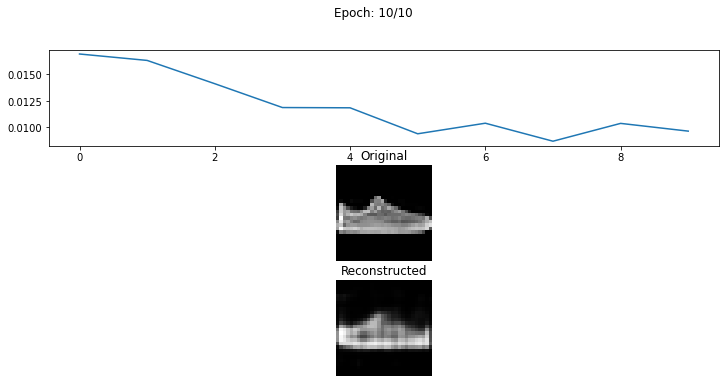

In [12]:
import time
from IPython.display import clear_output
%matplotlib inline
tf.keras.backend.clear_session()

conv_model = ConvolutionalAutoencoder(64) # I have no idea why 64 yet - maybe batch size?
num_epochs = 10
learning_rate = 0.001
train_losses = []
test_losses = []
loss_function = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam(learning_rate)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    start = time.perf_counter()
    
    #training (and checking in with training)
    for input in train_data:
        train_loss = train_step(conv_model, input, input, loss_function, optimizer)
    train_losses.append(train_loss)

    #train_data = train_data.shuffle(buffer_size=128)

    end = time.perf_counter()
    original_img, reconstructed_img = test(conv_model, test_data)


    # Plotting
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(3,1, figsize=(12,6))
    fig.suptitle(f"Epoch: {epoch+1}/{num_epochs}")
    ax[0].plot(train_losses)
    ax[1].imshow(original_img[0].numpy()[0], cmap="gray")
    ax[2].imshow(reconstructed_img[0].numpy()[0], cmap="gray")
    ax[1].set_title("Original")
    ax[2].set_title("Reconstructed")
    ax[1].axis("off")
    ax[2].axis("off")
    plt.show()

### Variational Autoencoder

Another thing that we need to take care if is how we compute the loss because it is different from what we have seen so far. Variational autoencoders train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood. Maximizing the ELBO actually minimizes the KL-divergence. By minimizing the KL-divergence we make sure that the distribution that we are learning is not very different from the standard Gaussian. 

Here, we optimize the single sample Monte Carlo estimate of this expectation: log p(x|z) + log p(z) - log q(z|x), where z is sampled from q(z|x). This is what we do in the `compute_loss`function. 

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


def train_step_2(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

The following is just a little helper function to generate and save images.

In [14]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Here, we fix some variables that we will need for the training. We train for 10 epochs and each epoch we generate 16 pictures to show the process during training. 

In [15]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
var_model = Var_Autoencoder(latent_dim)

In [16]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_data.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Finally, we can start our training. Let’s see what we get.

Epoch: 10, Test set ELBO: -273.5946960449219, time elapse for current epoch: 15.434489250183105


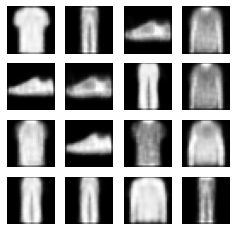

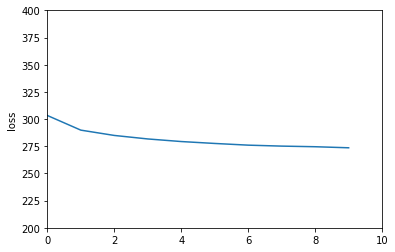

In [17]:
import time
from IPython import display
from IPython.display import clear_output
generate_and_save_images(var_model, 0, test_sample)
train_losses = []

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_data:
        train_step_2(var_model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_data:
        mean_loss = loss(compute_loss(var_model, test_x))
    train_losses.append(mean_loss)
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(var_model, epoch, test_sample)
    
    plt.ylabel('loss')
    plt.plot(train_losses)
    plt.axis([0,epoch,200,400])
    plt.show()

# Latent Space Analysis

<Explanation of latetent space analysis>

For this we will redo some part of our input pipeline. Otherwise there would be much conversion between tensorflow and numpy which would make the code unnecessarily messy.

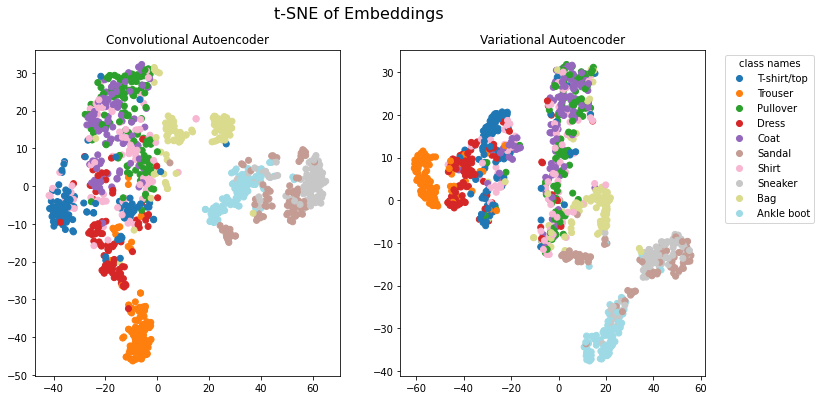

In [18]:
from sklearn.manifold import TSNE

# Preprossesing our images
images_to_encode = np.expand_dims(test_images[:1000]/255, (-1)).astype(np.float32)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Creating the embeddings
conv_embedded = conv_model.encoder(images_to_encode)
var_embedded = var_model.encoder(images_to_encode)

# Apply t-SNE
tsne = TSNE(n_components=2)
conv_tsne = tsne.fit_transform(conv_embedded)
var_tsne = tsne.fit_transform(var_embedded)

# Plotting the results
fig = plt.figure(figsize=(12,6))
fig.suptitle("t-SNE of Embeddings", fontsize=16)

plt.subplot(121) # syntactic sugar for plt.subplot(1,2,1)
plot_1 = plt.scatter(conv_tsne[:,0], conv_tsne[:,1], c=test_labels[:1000], cmap="tab20")
#plt.legend(handles = plot_1.legend_elements()[0], labels = class_names, title = 'class names', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Convolutional Autoencoder")

plt.subplot(122)
plot_2 = plt.scatter(var_tsne[:,0], var_tsne[:,1], c=test_labels[:1000], cmap="tab20")
plt.legend(handles = plot_2.legend_elements()[0], labels = class_names, title = 'class names', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variational Autoencoder")

plt.show()

#### Semantic Analysis

T-SNE is a tool to visualize high-dimensional data. It shows how similar (in our case) pictures are. We don't really care about the scales of the axes, but we just take a look at how close the data points are. 

Each point in the plot represents a picture of our fashion MNIST dataset (we only look at the first 1000 images of the test dataset).

As you can see both autoencoders do a pretty good job. In both cases ankle boots, sandals and sneakers are close together in the latent space, which makes sense because all of them are shoes. They also identify bags and trowsers to be separate classes.  Both struggle a little but to distinguish between pullovers, coats, shirts and at least some dresses. This makes sense because they can look quite similar, most of them have sleeves and maybe the same length. The variational autoencoder seems to do a slightly better job at distinguishing dresses. 

We already expected that the performance is pretty good even though the algorithm looks at the embeddings since the embeddings are supposed to contain all the important information.

# Interpolated embeddings

The real fun with autoencoders begins, when we start combining our learned representations to generate something new. In this exercise we take two random samples of our test dataset, create an embedding with each of our models and then interpolate the embeddings. Once this is done, we decode and display the images. Needless to say that we wanted to have some fun with the labels to, so we took them and combined them as well (in a crude, but simplistic way, I have to admit).

We noticed that the variational model gives an overall smoother image and is not as 
susceptible to "blank areas" (like you have with an image of a bag), while the convolutional model gives you a bit more contrast. Feel free to run the cell multiple times and see what fashionable masterpieces the autoencoders and a pseudo-random number generator can come up with.

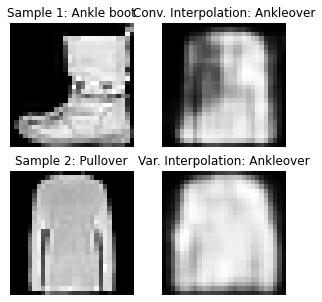

In [20]:
# Generate two random integers
rand1 = np.random.randint(images_to_encode.shape[0])
rand2 = np.random.randint(images_to_encode.shape[0])

samples = [images_to_encode[rand1], images_to_encode[rand2]]

# Store the labels as well so we know what we will mix
label1 = word_labels(test_labels[rand1]) 
label2 = word_labels(test_labels[rand2]) 

interpolation = np.mean(samples, axis = 0)
interpolation = np.expand_dims(interpolation, axis=0)

# Create the embeddings
conv_embeddings = conv_model.encoder(interpolation)
mean, logvar = var_model.encode(interpolation)
z = var_model.reparameterize(mean, logvar)

conv_interpolation_imgs = conv_model.decoder(conv_embeddings).numpy()
var_interpolation_imgs = var_model.sample(z).numpy()
    
fig = plt.figure(figsize=(5,5))
plt.subplot(221)
plt.imshow(samples[0], cmap="gray")
plt.axis("off")
plt.title(f"Sample 1: {label1}")

plt.subplot(223)
plt.imshow(samples[1], cmap="gray")
plt.axis("off")
plt.title(f"Sample 2: {label2}")

plt.subplot(222)
plt.imshow(conv_interpolation_imgs[0], cmap="gray")
plt.axis("off")
plt.title(f"Conv. Interpolation: {label1[:len(label1)//2]+label2[len(label2)//2:]}")

plt.subplot(224)
plt.imshow(var_interpolation_imgs[0], cmap="gray")
plt.axis("off")
plt.title(f"Var. Interpolation: {label1[:len(label1)//2]+label2[len(label2)//2:]}")

plt.show()